In [1]:
from PIL import Image, ImageDraw
import string
import random
import os
from pdf2image import convert_from_path 
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from fpdf import FPDF
import pytesseract
import bezier
import Levenshtein
import glob


In [2]:
def make_shadow(image):
    n = np.random.randint(2, 6)
    shadow = np.zeros((image.size[1], image.size[0]))
    
    pointsx = image.size[0]*np.random.random(n)
    pointsy = image.size[1]*np.random.random(n)
    
    shadow[(pointsy).astype(np.int), (pointsx).astype(np.int)] = 1
    shadow = ndimage.gaussian_filter(shadow, sigma=image.size[0] / (2 * n))
    
    image_arr = np.array(image.convert('LA'))[:, :, 0]
    image_arr = np.where(image_arr > 200, 255, 0)
    image_arr = np.where(image_arr == 255, image_arr - (shadow - np.min(shadow)) * 200 / np.max(shadow), image_arr)

    return Image.fromarray(np.uint8(image_arr))

In [3]:
def make_bezier_shadow(image):
    shadow = np.zeros((image.size[1], image.size[0]))
    n_curves = np.random.randint(2, 4)
    
    for i in range(n_curves):
        n_dots = np.random.randint(5, 9)
        
        pointsx = image.size[0]*np.random.random(n_dots)
        pointsy = image.size[1]*np.random.random(n_dots)
        
        curve1 = bezier.Curve(np.asfortranarray([pointsx, pointsy]), degree=n_dots-1)

        shadow_points = curve1.evaluate_multi(np.linspace(0.0, 1.0, 100))
        shadow[(shadow_points[1]).astype(int), (shadow_points[0]).astype(int)] = 1
    
    s = np.random.uniform(0.5, 0.9)
    shadow = ndimage.gaussian_filter(shadow, sigma=image.size[0] / (s * n_dots)).T
        
    darkness =  np.random.uniform(0.7, 0.85)
    shadow = 1 - darkness * (shadow - np.min(shadow)) / np.max(shadow)
    
    mask = np.where(shadow > 0.85, 0, 255)

    pixels = image.load()
    
    
    r = np.random.uniform(0.95, 1)
    g = np.random.uniform(0.95, 1)
    b = np.random.uniform(0.95, 1)

    for x in range(image.size[0]):
        for y in range(image.size[1]):
            pixels[x, y] =  (int(pixels[x, y][0] * r * shadow[x, y]),
                             int(pixels[x, y][1] * g * shadow[x, y]),
                             int(pixels[x, y][2] * b * shadow[x, y]))
            
            data = list(pixels[x, y])
            ind = np.random.randint(0, 2)
            g = 0.99
            
            data[ind] = int(data[ind] * g)#np.random.uniform(0.7, 1)
            pixels[x, y] = tuple(data)
                        
    return image, Image.fromarray(np.uint8(mask.T))
    

In [26]:

def make_samples(out_dir='', n_samples=100, inf=None):

    if len(out_dir) == 0:
        out_dir = os.getcwd()
    os.chdir(out_dir)
    
    try:
        os.mkdir('img')
    except:
        pass
    try:
        os.mkdir('gr')
    except:
        pass
    try:
        os.mkdir('mask')
    except:
        pass
    try:
        os.mkdir('txt')
    except:
        pass
    
    aligns = ['L', 'C', 'R']
    fonts = ['Courier', 'Arial', 'Times']
    styles = ['', 'B', 'I', 'U']
    
    for i in range(n_samples):
        pdf = FPDF() 
        pdf.add_page()
        
        font = random.choice(fonts)
    
        target = ''
        
        lines = random.randint(10, 13)
        
        for _ in range(lines):
            
            fontsize = random.randint(26,30)
            
            pdf.set_font(font, size=fontsize, style=random.choice(styles)) 
            r = random.randint(0, 30)
            g = random.randint(0, 30)
            b = random.randint(0, 30)

            pdf.set_text_color(r, g, b)

            str_size = random.randint(20,30)

            
            randomstr = ''.join(random.choices(string.ascii_letters + string.digits + ' ' * 20, k=str_size))
            target += randomstr + '\n'
        
            pdf.cell(w=0, h=fontsize/2, txt=randomstr, ln=1, align=random.choice(aligns)) 
        
        pdf.output('temp1.pdf')    
        image = convert_from_path('temp1.pdf', poppler_path=r'/usr/local/Cellar/poppler/21.04.0/bin')[0]
        image = image.resize((512, int(image.size[1] * 512 / image.size[0]))).crop((0,0,512,512))

        
        image_path = 'gr/' + str(i)+ '.jpg'
        image.save(image_path, 'JPEG')

        image, mask = make_bezier_shadow(image)
        
        mask_path = 'mask/' + str(i)+ '.jpg'
        mask.save(mask_path, 'JPEG')
        
        image_path = 'img/' + str(i)+ '.jpg'
        image.save(image_path, 'JPEG')
        
        target_path = 'txt/' + str(i)+ '.txt'
        text_file = open(target_path, "w")
        text_file.write(target)
        text_file.close()
        
        if inf is not None and i % 10 == 0:
            print('progress {:0.2f}'.format(i * 100/ n_samples), '%')
    
    os.remove('temp1.pdf')

In [27]:
make_samples(n_samples=200, inf=1)

progress 0.00 %
progress 5.00 %
progress 10.00 %
progress 15.00 %
progress 20.00 %
progress 25.00 %
progress 30.00 %
progress 35.00 %
progress 40.00 %
progress 45.00 %
progress 50.00 %
progress 55.00 %
progress 60.00 %
progress 65.00 %
progress 70.00 %
progress 75.00 %
progress 80.00 %
progress 85.00 %
progress 90.00 %
progress 95.00 %


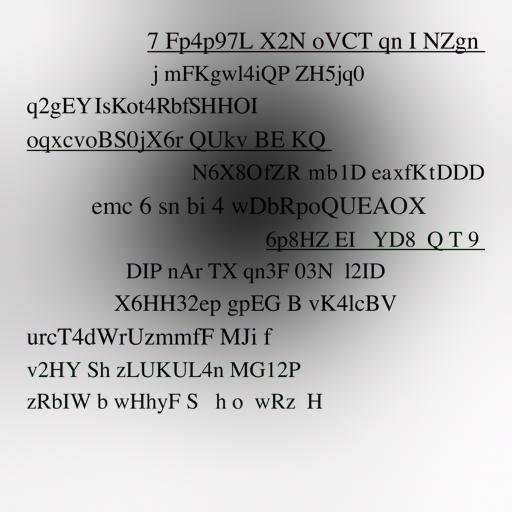

In [24]:
Image.open('img/0.jpg')

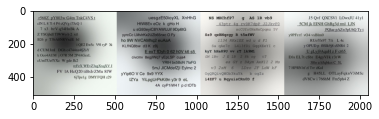

In [458]:
a = np.array(Image.open('img/0.jpg'))
b = np.array(Image.open('img/1.jpg'))
c = np.array(Image.open('img/2.jpg'))
d = np.array(Image.open('img/3.jpg'))

t = np.concatenate([a, b, c, d/], axis=1)
plt.imshow(t)


In [552]:
np.unique(np.array(Image.open('mask/0.jpg')))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        27,  28,  29,  33,  34,  35,  36,  37, 219, 222, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255], dtype=uint8)

In [8]:
def process_text(text):
  text = text.split("\n")
  text = list(map(lambda x: ' '.join(x.split()), text))
  text = "\n".join(text)
  return text

In [39]:
img = pytesseract.pytesseract.image_to_string(Image.open('img/0.jpg'))
img = process_text(img)
print(img)

V AUVyFx7FunKv2f g51XTJ1cwSH
sP F 1 CBLjo Fq | kwY2
Y iz6 CjEbPsthL XP iB 0 |
JPvp 3kR omOqTtT74i90 60
SY MzIKO kmG T 6p
HV AwC A c9 oPH3I3xk6g
zjp77Wi S5eJ mZryoZV





In [40]:
clear = pytesseract.pytesseract.image_to_string(Image.open('gr/0.jpg'))
clear = process_text(clear) 
print(clear)

V AUVyFx7FunKv2f g51XTJ1cwSH
sP F 1 CBLjo Fq I kwY2
Y iz6 CjEbPsthL XP iB 0 |
JPvp 3kR omOqTtT74i90 60
SY MzIKO kmG T 6p
HV AwCA c9 oPH3I3xk6g
zjp77Wi S5eJ mZ ryoZV
u91bgfJ EyiH u z eeYL Stl QDQF
a ve7 SOsbjkUClo gwCs tww
iQx OHr U4M Dté fS_ D
GsZwTTBahNxX2lv fFaBvxqd w
a5U YQ hsrhvQ9i YUe g
c cO78s9Z sluJ g9Md 06
XU oY! goP gzrq sKn GVx bcZ
F1V1 vGNg eXo38rYLaR SXkI
CCqPtiFB VRgud | Y 8eUb
qkj 5WWKYA p_ n3tV709b1Nu20
JNIq c 1u4ppnObO2 kM au
NPtBInNpY 1uA6BWOU v jkV
Oy Sx q SB f3 7PY
Azv Ua | Q3V pD387WqF E3G1U
qOKa qqBQRph fOnwVxXWy5V Q DJ



In [34]:
res = pytesseract.pytesseract.image_to_string(Image.open('res/0.jpg'))
res = process_text(res)
print(res)

FileNotFoundError: ignored

In [22]:
f = open("txt/0.txt")
gr = ''.join(f.readlines())
gr = process_text(gr)
print(gr)

4SIpS4w92BJ9ed Oo1Z Ol7WWiLrT
W 7 i9 CK Q Sfup94og igQa
W gOL G 2 pG36y h1 Cl 2
k bozy4 Wgm6nhoNM5iNb0m4jV
ho KcH pwFj aNW UVQAMI
Lu Gbq JPEE5Kj5 7U1
Zn s 1Hev5 5vmYk OJZ18hw 3
vy4a LfJ 6x6k5tThbg CtL4 3l
o1 A 3 BT qZi2 8Kw1Tnqc
9 PEP h A Tym6UolJ E0
w l nLPJ5DU C V9zyMZbgBlW
Is Mhy 4BFH wRg6Vs



In [42]:
import Levenshtein
Levenshtein.distance(clear, img)

383

In [ ]:
Levenshtein.distance(clear, res)

15

In [41]:
Levenshtein.distance(clear, gr)

32

In [97]:
def process_removal_results(res_path):

    res_files = sorted(glob.glob(res_path + '/*.*'))
    txt_gt_files = sorted(glob.glob('/Users/nikitaborisov/stud/kursach/dataset/colored_test/txt/*.*'))
    img_gt_files = sorted(glob.glob('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_C/*.*'))
    img_shadow_files = sorted(glob.glob('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_A/*.*'))
    

    assert(len(res_files) == len(txt_gt_files) == len(img_gt_files) == len(img_shadow_files))
    
    avg_res_gt = 0
    avg_res_img_gt = 0
    avg_gt_img_gt = 0
    avg_s_gt = 0
    avg_s_img_gt = 0
        
    avg_mse = 0
    avg_mae = 0
    
    for i in range(len(res_files)):
        res_img = Image.open(res_files[i % len(res_files)])
        res_txt = process_text(pytesseract.pytesseract.image_to_string(res_img))
        
        gt_img = Image.open(img_gt_files[i % len(res_files)])
#         gt_img_txt = process_text(pytesseract.pytesseract.image_to_string(gt_img))


#         s_img = Image.open(img_shadow_files[i % len(res_files)])
#         s_img_txt = process_text(pytesseract.pytesseract.image_to_string(s_img))

        gt_f = open(txt_gt_files[i % len(res_files)])
        gt_txt =  process_text(''.join(gt_f.readlines()))
        
        
        text_len = len(gt_txt)
        
        res_gt = Levenshtein.distance(res_txt, gt_txt) / text_len
#         res_img_gt = Levenshtein.distance(res_txt, gt_img_txt) / text_len
        
#         gt_img_gt = Levenshtein.distance(gt_txt, gt_img_txt) / text_len
        
#         s_gt = Levenshtein.distance(s_img_txt, gt_txt) / text_len
#         s_gt_img = Levenshtein.distance(s_img_txt, gt_img_txt) / text_len
        
        mse = ((np.asanyarray(res_img) - np.asanyarray(gt_img))**2).mean(axis=None)
        mae = (np.absolute((np.asanyarray(res_img) - np.asanyarray(gt_img)))).mean(axis=None)
        
        avg_res_gt += res_gt 
#         avg_res_img_gt += res_img_gt 
#         avg_gt_img_gt += gt_img_gt
#         avg_s_gt += s_gt 
#         avg_s_img_gt += s_gt_img 
        
        avg_mse += mse
        avg_mae += mae 
        
        
        if (i % 10 == 0):
            print(i * 100 / len(res_files), "%")
            

        
    print('avg distance:')
    print(' result -x- gt text: ', avg_res_gt)
#     print(' gt image -x- gt text: ', avg_gt_img_gt)
#     print(' s image -x- gt text: ', avg_s_gt)



#     print()

#     print(' result -x- gt image: ', avg_res_img_gt)
#     print(' s image -x- gt image: ', avg_s_img_gt)

    print()
    print('avg mse: ', avg_mse)
    print('avg mae: ', avg_mae)
    


        
        
        

In [100]:
process_removal_results('/Users/nikitaborisov/stud/kursach/white_res_doc')

0.0 %
5.0 %
10.0 %
15.0 %
20.0 %
25.0 %
30.0 %
35.0 %
40.0 %
45.0 %
50.0 %
55.0 %
60.0 %
65.0 %
70.0 %
75.0 %
80.0 %
85.0 %
90.0 %
95.0 %
avg distance:
 result -x- gt text:  16.892132654356324

avg mse:  4149.897830963135
avg mae:  22964.56789779664


In [164]:
rgb_smooth = ['3.jpg','4.jpg','5.jpg','8.jpg','10.jpg','13.jpg', '14.jpg', '17.jpg']
rgb_sharp = ['0.jpg', '2.jpg', '7.jpg', '19.jpg']


imgs = rgb_smooth + rgb_sharp

avg_mae = 0
avg_mse = 0

for item in imgs:
    res_img = Image.open('/Users/nikitaborisov/stud/kursach/our/result_syn_our_unet/' + item)        
    gt_img = Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_C/' + item)

    mse = ((np.asanyarray(res_img) - np.asanyarray(gt_img))**2).mean(axis=None)
    mae = (np.absolute((np.asanyarray(res_img) - np.asanyarray(gt_img)))).mean(axis=None)
        
    avg_mse += mse
    avg_mae += mae

print('rgb')
print('avg mse = ', avg_mse/12)
print('avg mae = ', avg_mae/12)


    

rgb
avg mse =  15.228757858276367
avg mae =  43.68368403116862


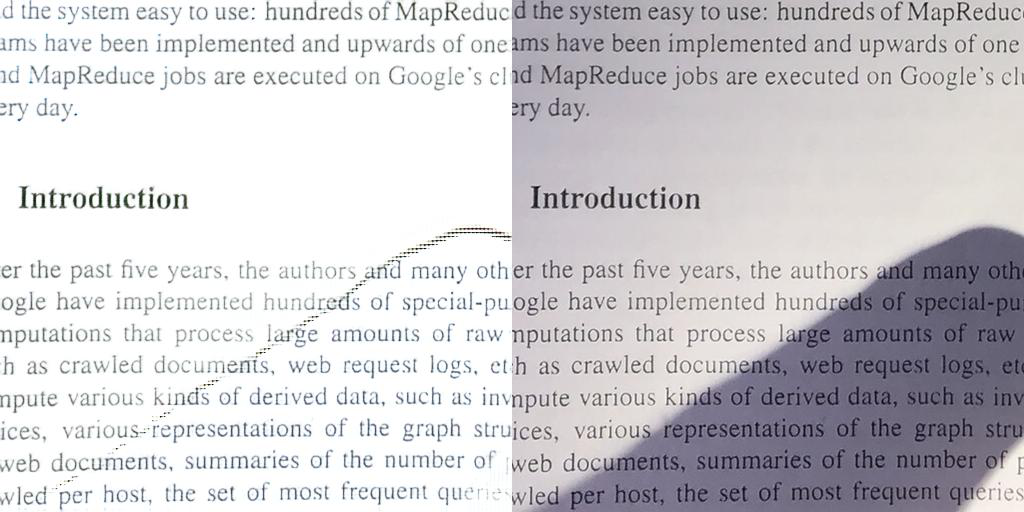

In [271]:
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/impl/result_real_msgan /9.jpg').resize((512,512)))
gt_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/real_data/9.jpg').resize((512,512)))
pic = np.concatenate((res_img, gt_img), axis=1)
Image.fromarray(pic, 'RGB')




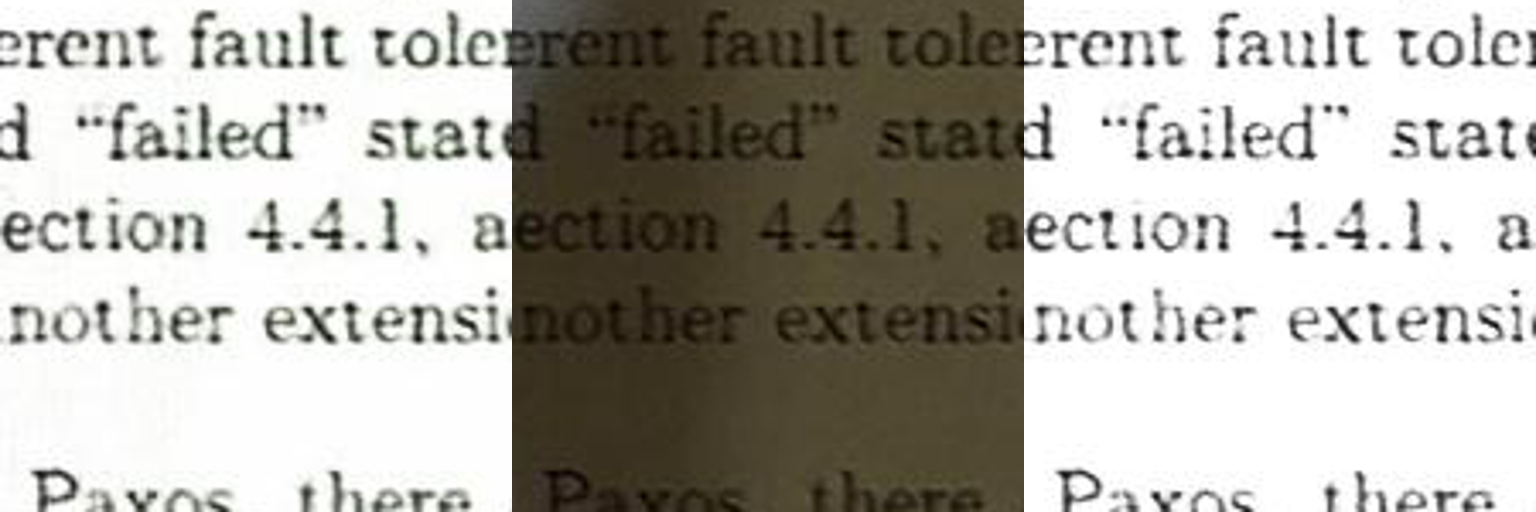

In [267]:
res_s = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/impl/result_real_stcgan/12.jpg').crop((330,150,480,300)).resize((512,512)))
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/our/result_real_our_unet/12.jpg').crop((330,150,480,300)).resize((512,512)))
gt_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/real_data/12.jpg').crop((330,150,480,300)).resize((512,512)))
pic = np.concatenate((res_img, gt_img, res_s), axis=1)
Image.fromarray(pic, 'RGB')



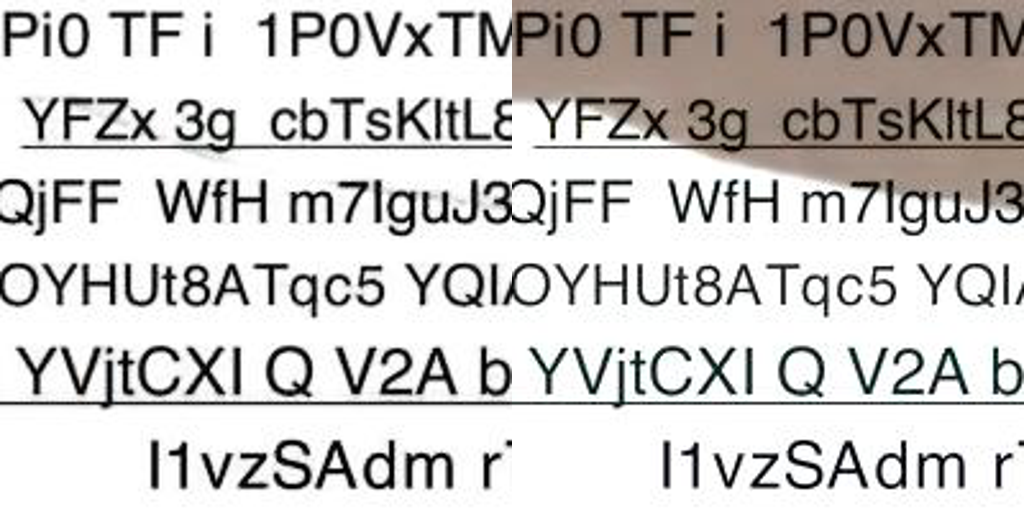

In [261]:
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/our/result_syn_our_unet/52.jpg').crop((130,130,330,330)).resize((512,512)))
gt_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_A/52.jpg').crop((130,130,330,330)).resize((512,512)))
pic = np.concatenate((res_img, gt_img), axis=1)
Image.fromarray(pic, 'RGB')



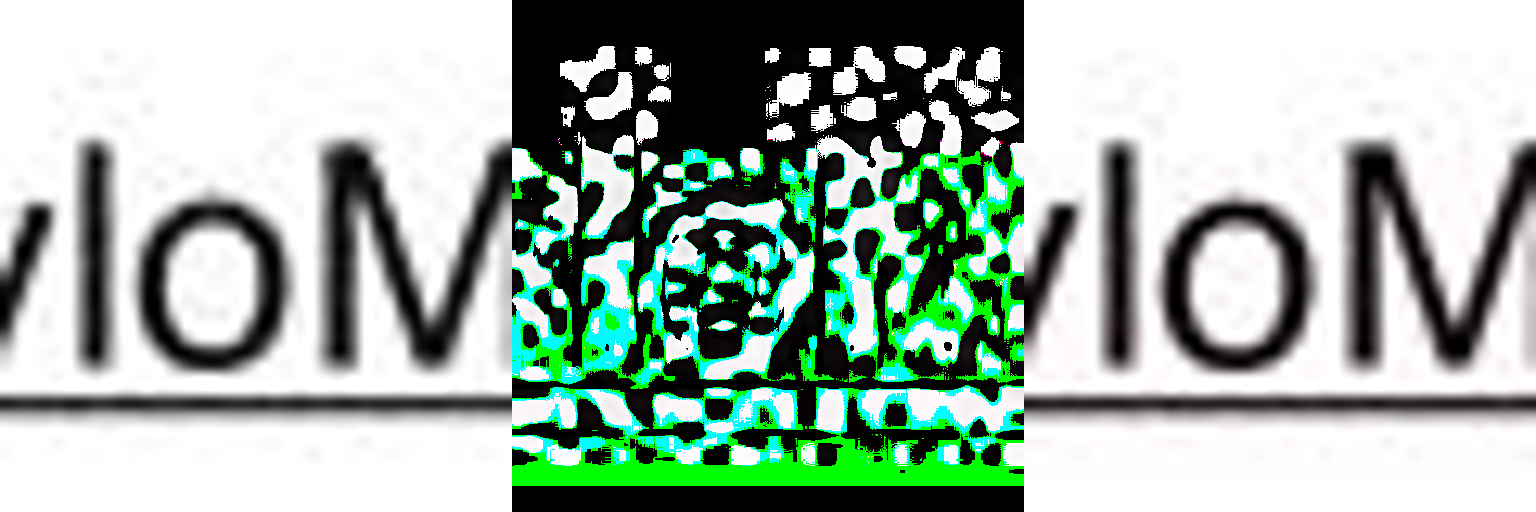

In [234]:
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/impl/result_syn_stcgan/51.jpg').crop((180,20,220,60)).resize((512,512)))
gt_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_C/51.jpg').crop((180,20,220,60)).resize((512,512)))
pic = np.concatenate((res_img, gt_img - res_img, gt_img), axis=1)
Image.fromarray(pic, 'RGB')





In [ ]:
img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/real_data/4.jpg').crop((100,280,250,430)).resize((512,512)))
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/impl/result_real_stcgan/4.jpg').crop((100,280,250,430)).resize((512,512)))
pic = np.concatenate((res_img, img), axis=1)
Image.fromarray(pic, 'RGB')



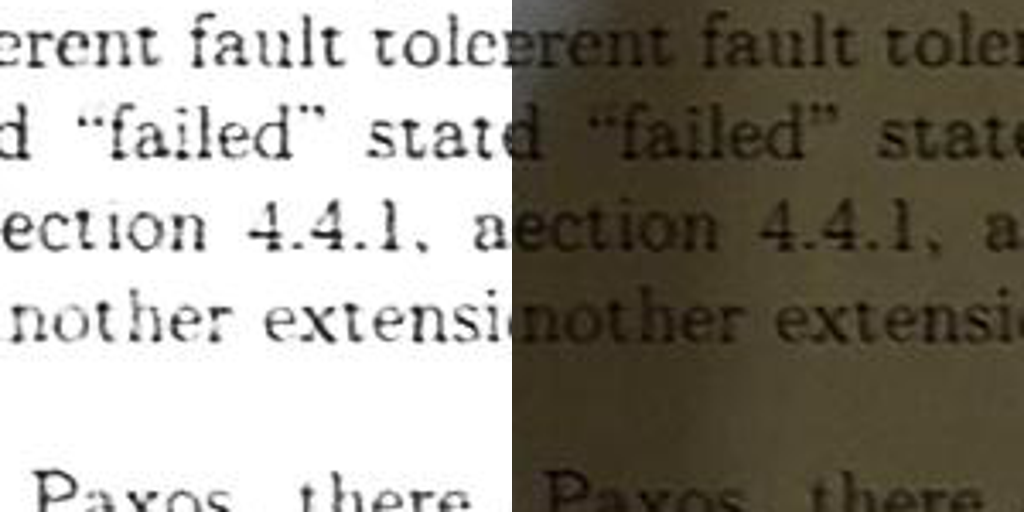

In [239]:
img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/real_data/12.jpg').crop((330,150,480,300)).resize((512,512)))
res_img = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/impl/result_real_stcgan/12.jpg').crop((330,150,480,300)).resize((512,512)))
pic = np.concatenate((res_img, img), axis=1)
Image.fromarray(pic, 'RGB')



In [165]:
gs_sharp = ['1.jpg', '6.jpg', '16.jpg', '20.jpg']

avg_mae = 0
avg_mse = 0

for item in gs_sharp:
    res_img = Image.open('/Users/nikitaborisov/stud/kursach/our/result_syn_our_unet/' + item) 
    gt_img = Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_C/' + item)
    
    mse = ((np.asanyarray(res_img) - np.asanyarray(gt_img))**2).mean(axis=None)
    mae = (np.absolute((np.asanyarray(res_img) - np.asanyarray(gt_img)))).mean(axis=None)
        
    avg_mse += mse
    avg_mae += mae

print('greyscale')

print('avg mse = ', avg_mse/4)
print('avg mae = ', avg_mae/4)





greyscale
avg mse =  16.75090503692627
avg mae =  48.99290053049723


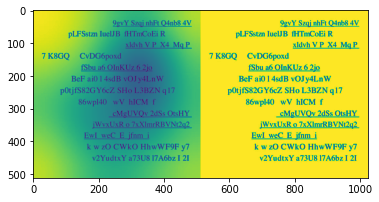

In [152]:
s = np.array(Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_A/55.jpg').convert('L')).astype(int)
gt = np.array(Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_C/55.jpg').convert('L')).astype(int)

plt.figure
plt.imshow(np.concatenate([s, gt], axis=1))

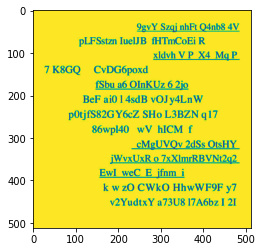

In [154]:
x = gt / (s + 0.001)
f = s * x
plt.imshow(f)

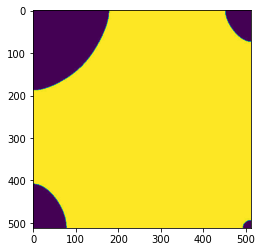

In [122]:
mask = np.asanyarray(Image.open('/Users/nikitaborisov/stud/kursach/dataset/colored_test/train_B/55.jpg').convert('L'))
plt.imshow(mask)
